In [66]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.preprocessing import  StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.tree import DecisionTreeRegressor

In [67]:
salary_data= pd.read_csv('./data_files/levels_fyi_Salary_Data.csv')
salary_data.head()

,timestamp,company,level,title,totalyearlycompensation,location,yearsofexperience,yearsatcompany,tag,basesalary,...,Doctorate_Degree,Highschool,Some_College,Race_Asian,Race_White,Race_Two_Or_More,Race_Black,Race_Hispanic,Race,Education
0,6/7/2017 11:33:27,Oracle,L3,Product Manager,127000,"Redwood City, CA",1.5,1.5,NaN,107000.0,...,0,0,0,0,0,0,0,0,NaN,NaN
1,6/10/2017 17:11:29,eBay,SE 2,Software Engineer,100000,"San Francisco, CA",5.0,3.0,NaN,0.0,...,0,0,0,0,0,0,0,0,NaN,NaN
2,6/11/2017 14:53:57,Amazon,L7,Product Manager,310000,"Seattle, WA",8.0,0.0,NaN,155000.0,...,0,0,0,0,0,0,0,0,NaN,NaN
3,6/17/2017 0:23:14,Apple,M1,Software Engineering Manager,372000,"Sunnyvale, CA",7.0,5.0,NaN,157000.0,...,0,0,0,0,0,0,0,0,NaN,NaN
4,6/20/2017 10:58:51,Microsoft,60,Software Engineer,157000,"Mountain View, CA",5.0,3.0,NaN,0.0,...,0,0,0,0,0,0,0,0,NaN,NaN


In [68]:
salary_data.dtypes

timestamp                   object
company                     object
level                       object
title                       object
totalyearlycompensation      int64
location                    object
yearsofexperience          float64
yearsatcompany             float64
tag                         object
basesalary                 float64
stockgrantvalue            float64
bonus                      float64
gender                      object
otherdetails                object
cityid                       int64
dmaid                      float64
rowNumber                    int64
Masters_Degree               int64
Bachelors_Degree             int64
Doctorate_Degree             int64
Highschool                   int64
Some_College                 int64
Race_Asian                   int64
Race_White                   int64
Race_Two_Or_More             int64
Race_Black                   int64
Race_Hispanic                int64
Race                        object
Education           

# Inital drops for columns without a use
## Timestamp column doesnt have any use to me for this data set so it will be dropped
## tag has a lot of missing values and wouldnt be any use to keep for predictions
## race coloumn is just redunent since each race is already ohe
## Education has to many missing values to make assumtions for what they could be. It's better to drop
## Otherdetails is a more detailed description of their race, job title, and education same as before its reduntent so we dont need it 
## Rownumber seams like just a secondary index so it can be dropped 

In [69]:
salary_data.drop(columns=['timestamp', 'tag','Race','Education', 'otherdetails', 'rowNumber'], inplace=True)

In [70]:
salary_data.isnull().sum()

company                        5
level                        119
title                          0
totalyearlycompensation        0
location                       0
yearsofexperience              0
yearsatcompany                 0
basesalary                     0
stockgrantvalue                0
bonus                          0
gender                     19540
cityid                         0
dmaid                          2
Masters_Degree                 0
Bachelors_Degree               0
Doctorate_Degree               0
Highschool                     0
Some_College                   0
Race_Asian                     0
Race_White                     0
Race_Two_Or_More               0
Race_Black                     0
Race_Hispanic                  0
dtype: int64

## There is a lot of comapnys and when trying to Ohe later this will create way to many separte columns so instead of having all these I think it will be better to compare non FAANG companies vs the FAANG companies  (Facebook, Amazon, Apple, Nextflix, Google)

In [71]:
len(salary_data['company'].unique())

1632

In [72]:
faang = ['Facebook', 'Amazon','Apple', 'Netflix','Google']

In [73]:
salary_data.loc[salary_data['company'].isin(faang), 'company'] = 'FAANG'

In [74]:
salary_data.loc[salary_data['company'] != 'FAANG', 'company'] = 'not_FAANG'

In [75]:
salary_data['company'].unique()

array(['not_FAANG', 'FAANG'], dtype=object)

## There is a significant amount of missing values in the gender column this might be due to these workers not wanting to share that information so we will fill these with 'unknown'. and there is one lingering 'Title: Senior Software Engineer' so that will be changed to 'unknown' as well

In [76]:
salary_data['gender'].unique()

array([nan, 'Male', 'Female', 'Other', 'Title: Senior Software Engineer'],
      dtype=object)

In [77]:
salary_data['gender'].fillna('unknown', inplace=True)
salary_data['gender'].replace({'Title: Senior Software Engineer': 'unknown'}, inplace=True )

## There is a lot of different levels and there is also other columns that tell the same story ie. yearsatcompany, yearsofexp, etc. So this will be dropped

In [78]:
len(salary_data['level'].unique())
salary_data.drop(columns='level', inplace=True)

In [79]:
salary_data['location']

0         Redwood City, CA
1        San Francisco, CA
2              Seattle, WA
3            Sunnyvale, CA
4        Mountain View, CA
               ...        
62637          Seattle, WA
62638          Redmond, WA
62639          Seattle, WA
62640    San Francisco, CA
62641        Sunnyvale, CA
Name: location, Length: 62642, dtype: object

In [80]:
#adds new column for the countries (however some states within the usa and not under USA these will be handeled later)
salary_data['country'] = salary_data['location'].apply(lambda x: x.split(',')[-1].strip(' '))

In [81]:
salary_data['country'].unique()

array(['CA', 'WA', 'United Kingdom', 'NY', 'Ireland', 'MD', 'OR', 'India',
       'Belarus', 'DC', 'Canada', 'TX', 'MA', 'LA', 'PA', 'SC', 'Russia',
       'VA', 'CO', 'NE', 'IN', 'WI', 'MN', 'Netherlands', 'Switzerland',
       'Singapore', 'IL', 'Germany', 'NJ', 'Japan', 'AZ', 'Sweden',
       'Australia', 'United States', 'Israel', 'Poland', 'OH', 'China',
       'NC', 'Austria', 'Luxembourg', 'FL', 'GA', 'MO', 'Czech Republic',
       'RI', 'UT', 'France', 'Pakistan', 'New Zealand', 'Denmark', 'MI',
       'Hong Kong (SAR)', 'South Africa', 'Spain', 'CT',
       'United Arab Emirates', 'NM', 'AR', 'VT', 'Hungary', 'IA',
       'Brazil', 'Bulgaria', 'KS', 'NH', 'ID', 'Philippines', 'TN',
       'Indonesia', 'Puerto Rico', 'Taiwan', 'DE', 'Romania', 'AL',
       'Mexico', 'NV', 'Costa Rica', 'Marshall Islands', 'Vietnam',
       'Panama', 'KY', 'Argentina', 'Norway', 'Moldova', 'Estonia',
       'Kenya', 'Turkey', 'Italy', 'Lithuania', 'Nigeria', 'WV', 'South',
       'Ukraine', 'Jor

## Replaces all the states to one United States (processing if statements within lambda functions [here](https://stackoverflow.com/questions/1585322/is-there-a-way-to-perform-if-in-pythons-lambda ))

In [82]:
salary_data['country'] = salary_data['country'].apply(lambda x: 'United States' if len(x) == 2 else x)
#Now we can drop the location and cityid since they are sparated by the country in the new column
salary_data.drop(columns=['location', 'cityid'], inplace=True)

## Wasn't to sure on what dmaId was so I looked up how others tackled this since there are 2 missing values. [Here](https://www.kaggle.com/kwangyangchia/midterm-project-for-mle/notebook?scriptVersionId=77536394&cellId=50) they used median to fill the missing values since the dmaid column isnt distruibuted to well so I will do the same. 

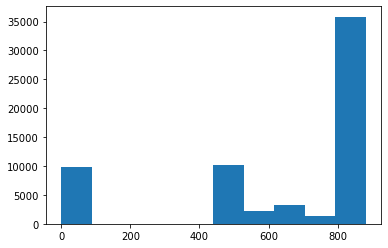

In [83]:
plt.hist(salary_data['dmaid'])
plt.show()

In [84]:
salary_data['dmaid'].fillna(salary_data['dmaid'].median(), inplace=True)

# Final check for missing values and incorrect dtypes

In [85]:
salary_data.isnull().sum()

company                    0
title                      0
totalyearlycompensation    0
yearsofexperience          0
yearsatcompany             0
basesalary                 0
stockgrantvalue            0
bonus                      0
gender                     0
dmaid                      0
Masters_Degree             0
Bachelors_Degree           0
Doctorate_Degree           0
Highschool                 0
Some_College               0
Race_Asian                 0
Race_White                 0
Race_Two_Or_More           0
Race_Black                 0
Race_Hispanic              0
country                    0
dtype: int64

In [86]:
salary_data.dtypes

company                     object
title                       object
totalyearlycompensation      int64
yearsofexperience          float64
yearsatcompany             float64
basesalary                 float64
stockgrantvalue            float64
bonus                      float64
gender                      object
dmaid                      float64
Masters_Degree               int64
Bachelors_Degree             int64
Doctorate_Degree             int64
Highschool                   int64
Some_College                 int64
Race_Asian                   int64
Race_White                   int64
Race_Two_Or_More             int64
Race_Black                   int64
Race_Hispanic                int64
country                     object
dtype: object

## Removal of scientific notation code [link](https://stackoverflow.com/questions/40347689/dataframe-describe-suppress-scientific-notation)

## With looking at the .describe() the only inconsistancy I see is that the basesalary  has a min of 0 this could be due to a number of things such as unpaid interships etc. However, there is a bouns and totalyearlycompensation columns since just the totalyearly compensation would cover the basesalary alone we can drop the baseSalary column 

In [87]:
salary_data.describe().apply(lambda s: s.apply('{0:.5f}'.format))

,totalyearlycompensation,yearsofexperience,yearsatcompany,basesalary,stockgrantvalue,bonus,dmaid,Masters_Degree,Bachelors_Degree,Doctorate_Degree,Highschool,Some_College,Race_Asian,Race_White,Race_Two_Or_More,Race_Black,Race_Hispanic
count,62642.00000,62642.00000,62642.00000,62642.00000,62642.00000,62642.00000,62642.00000,62642.00000,62642.00000,62642.00000,62642.00000,62642.00000,62642.00000,62642.00000,62642.00000,62642.00000,62642.00000
mean,216300.37365,7.20414,2.70209,136687.28130,51486.08073,19334.74659,616.10332,0.24570,0.20122,0.02878,0.00511,0.00567,0.18793,0.12822,0.01283,0.01101,0.01804
std,138033.74638,5.84038,3.26366,61369.27806,81874.56939,26781.29204,289.84077,0.43050,0.40092,0.16720,0.07129,0.07507,0.39066,0.33434,0.11256,0.10437,0.13309
min,10000.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
25%,135000.00000,3.00000,0.00000,108000.00000,0.00000,1000.00000,506.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
50%,188000.00000,6.00000,2.00000,140000.00000,25000.00000,14000.00000,807.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
75%,264000.00000,10.00000,4.00000,170000.00000,65000.00000,26000.00000,807.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
max,4980000.00000,69.00000,69.00000,1659870.00000,2800000.00000,1000000.00000,881.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000


In [88]:
salary_data.drop(columns='basesalary', inplace=True)

## We also have a major outlier in yearsofexperience and yearsatcompany of 69. Now this could true since its only one value and very unlikely that someone would stay at the same job for 69 years im going to drop it to not skew any of our data later

In [89]:
salary_data.loc[salary_data['yearsofexperience'] == 69]

,company,title,totalyearlycompensation,yearsofexperience,yearsatcompany,stockgrantvalue,bonus,gender,dmaid,Masters_Degree,Bachelors_Degree,Doctorate_Degree,Highschool,Some_College,Race_Asian,Race_White,Race_Two_Or_More,Race_Black,Race_Hispanic,country
46988,not_FAANG,Product Designer,102000,69.0,69.0,2000.0,0.0,unknown,512.0,0,0,0,0,0,0,0,0,0,0,United States


In [90]:
salary_data.drop(index=46988, inplace=True)

# Missing Values within ohe school columns
## Finally, since there were some columns that were already ohe I want to check how many are missing (all rows are 0s) in order to check this I will add up all the 1s for each column and subtract that from the total amount of rows

## So if more than half are missing it might be best to drop these columns as they are no use if over half are just 0s

In [91]:
masters_degree_values = salary_data['Masters_Degree'].value_counts()[1]
bachelors_degree_values = salary_data['Bachelors_Degree'].value_counts()[1]
doctorate_degree_values = salary_data['Doctorate_Degree'].value_counts()[1]
highschool_values = salary_data['Highschool'].value_counts()[1]
some_college_values = salary_data['Some_College'].value_counts()[1]
total = masters_degree_values + bachelors_degree_values +doctorate_degree_values + highschool_values + some_college_values
print(f'Of: {len(salary_data)}. There are {len(salary_data) - total} missing')

salary_data.drop(columns=['Masters_Degree','Bachelors_Degree','Doctorate_Degree','Highschool','Some_College'], inplace=True)

Of: 62641. There are 32167 missing


# Missing Values within ohe race columns

## Even more of these are missing than the schooling columns so they will be dropped as well Since there is 40,000 of 62,000 that are missing.

## Dropping these columns doesnt change much with a base KNN model ran in a test with all columns the run time took 6 minutes and gave a score of 
## Training:  0.852341136615955   
## Testing: 0.7662578155179134 


## With the columns dropped we get a base KNN the run time takes 56.5s this is still not where I want the run time to be. To fix the runtime the country column could be dropped as well since that is Ohe 80 separate columns and it wouldnt have to big of an impact on our socres. Also, as we can see that even with dropping the Race and schooling columns we even got better scores.
## Training: 0.8654675813443405
## Testing: 0.7853139750419953

In [92]:
salary_data.head()
Race_Asian_values = salary_data['Race_Asian'].value_counts()[1]
Race_White_values = salary_data['Race_White'].value_counts()[1]
Race_Two_Or_More_values = salary_data['Race_Two_Or_More'].value_counts()[1]
Race_Black_values = salary_data['Race_Black'].value_counts()[1]
Race_Hispanic_values = salary_data['Race_Hispanic'].value_counts()[1]
total = Race_Asian_values + Race_White_values + Race_Two_Or_More_values + Race_Black_values + Race_Hispanic_values 
print(f'Of: {len(salary_data)}. There are {len(salary_data) - total} missing')

salary_data.drop(columns=['Race_Asian','Race_White','Race_Two_Or_More','Race_Black','Race_Hispanic'], inplace=True)

Of: 62641. There are 40213 missing


In [93]:
salary_data.head()

,company,title,totalyearlycompensation,yearsofexperience,yearsatcompany,stockgrantvalue,bonus,gender,dmaid,country
0,not_FAANG,Product Manager,127000,1.5,1.5,20000.0,10000.0,unknown,807.0,United States
1,not_FAANG,Software Engineer,100000,5.0,3.0,0.0,0.0,unknown,807.0,United States
2,FAANG,Product Manager,310000,8.0,0.0,0.0,0.0,unknown,819.0,United States
3,FAANG,Software Engineering Manager,372000,7.0,5.0,180000.0,35000.0,unknown,807.0,United States
4,not_FAANG,Software Engineer,157000,5.0,3.0,0.0,0.0,unknown,807.0,United States


# Corr Plot

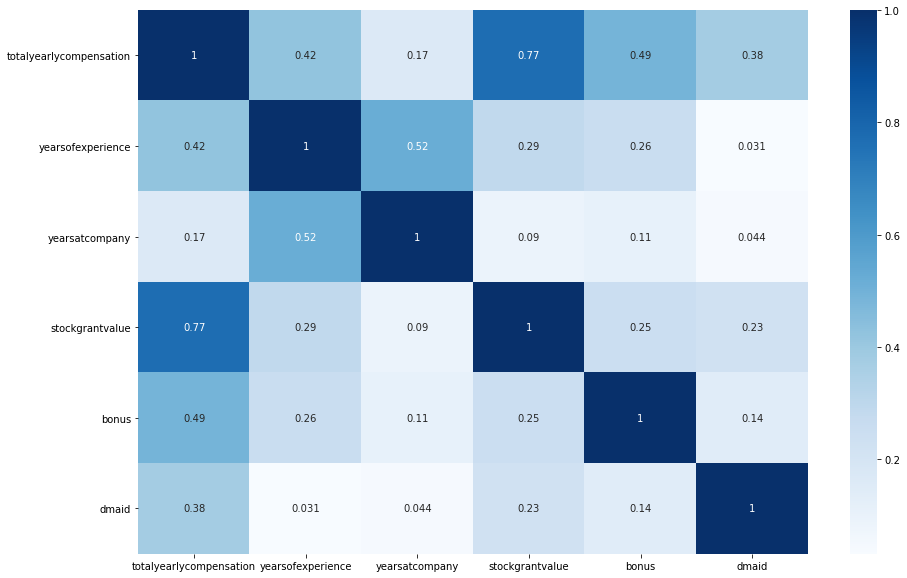

money/dollar values have high corr. Same with years of exp and years at company


In [94]:
corr = salary_data.corr()
plt.figure(figsize=(15,10))
sns.heatmap(corr, annot=True, cmap='Blues')
plt.show()
print('money/dollar values have high corr. Same with years of exp and years at company')

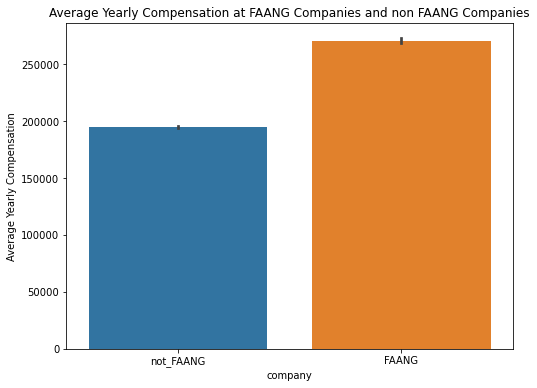

We have to keep in mind that even though Faang companies are higher the ratio of 5 companies in FAANG to all the others not in FAANG is very uneven


In [95]:
plt.figure(figsize=(8,6))
sns.barplot(salary_data['company'], salary_data['totalyearlycompensation'])
plt.ylabel('Average Yearly Compensation')
plt.title('Average Yearly Compensation at FAANG Companies and non FAANG Companies')
plt.show()
print('We have to keep in mind that even though Faang companies are higher the ratio of 5 companies in FAANG to all the others not in FAANG is very uneven')

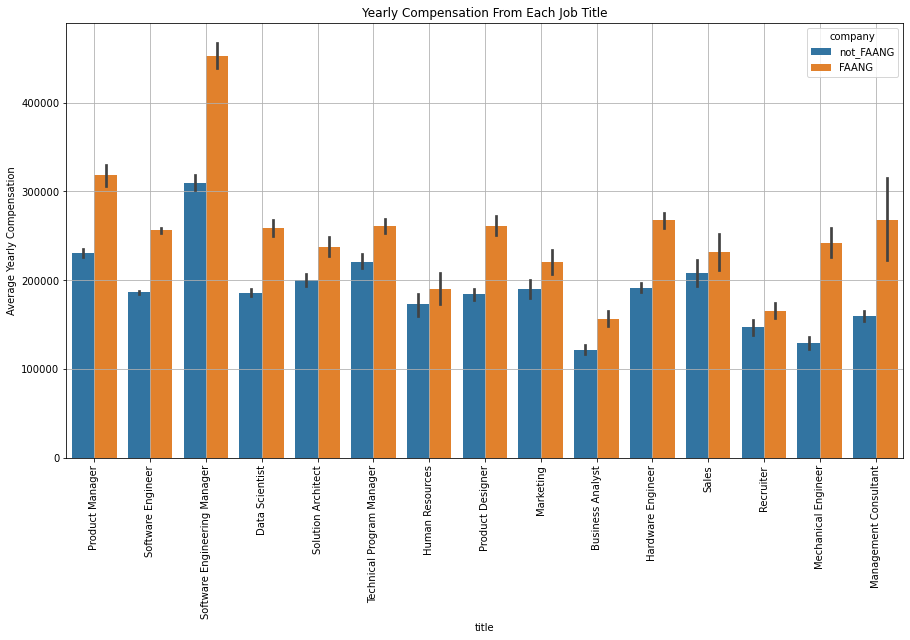

Kept consistant from the graph above all job titles at FAANG are paid more than positions at non FAANG companies. 
Also, we can see that the top 3 paid positions are softwear Engineer, Product Manager, and Hardware Engineer. 


In [96]:
plt.figure(figsize=(15,8))
bar_plot = sns.barplot(salary_data['title'], salary_data['totalyearlycompensation'], hue=salary_data['company'])
plt.ylabel('Average Yearly Compensation')
plt.title('Yearly Compensation From Each Job Title')
plt.xticks(rotation=90)
plt.grid()
plt.show()
print('''Kept consistant from the graph above all job titles at FAANG are paid more than positions at non FAANG companies. 
Also, we can see that the top 3 paid positions are softwear Engineer, Product Manager, and Hardware Engineer. ''')

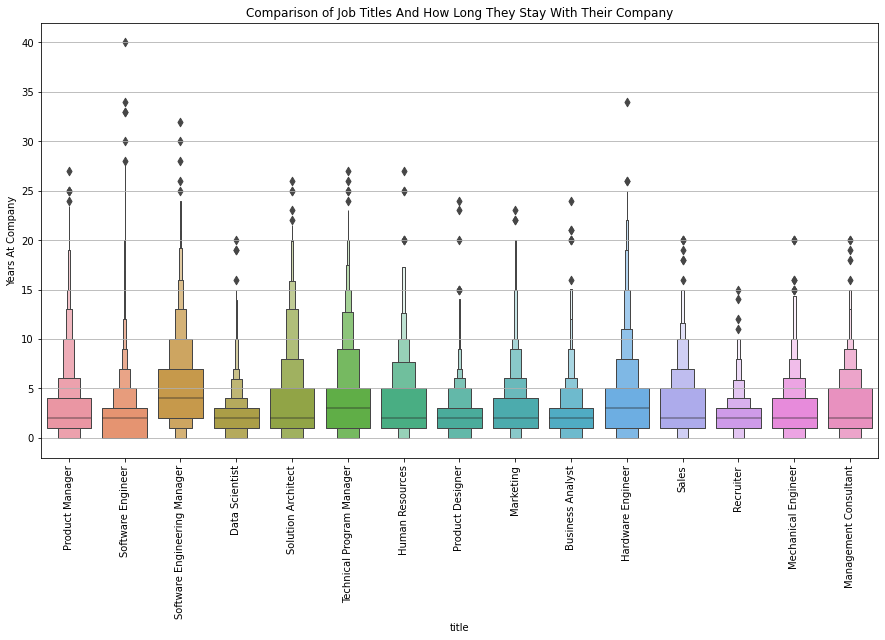

From this graph its clear that software engineers stay the longest at their jobs. This is mostlikely do to the fact that they are the highest paid job out of all jobs listed


In [97]:
plt.figure(figsize=(15,8))
sns.boxenplot(salary_data['title'], salary_data['yearsatcompany'])
plt.xticks(rotation= 90)
plt.title('Comparison of Job Titles And How Long They Stay With Their Company')
plt.ylabel('Years At Company')
plt.grid(axis='y')
plt.show()
print('From this graph its clear that software engineers stay the longest at their jobs. This is mostlikely do to the fact that they are the highest paid job out of all jobs listed')

# Machine Learning

## Dropping the main target but also dropping the countries column so the model run time is better and its not ohe 80 separate columns the job title column could also be dropped for even better run times and I chose do do this one as well since even in the upper 17s for runtime still isnt the best but with both dropped the run time is around 5s

In [98]:
X = salary_data.drop(columns=['totalyearlycompensation', 'country', 'title'])
y = salary_data['totalyearlycompensation']

In [99]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

## Ohe for gender and company columns

In [103]:
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

ohe_X_train = X_train[['company', 'gender']]
ohe_X_test = X_test[['company', 'gender']]

ohe.fit(ohe_X_train)

ohe_X_train_transform = ohe.transform(ohe_X_train)
ohe_X_test_transform = ohe.transform(ohe_X_test)

## Standard Scaler for all columns except for the ohe columns 

In [104]:
scaler = StandardScaler()

scaled_X_train = X_train.drop(columns=['company','gender'])
scaled_X_test = X_test.drop(columns=['company','gender'])

scaler.fit(scaled_X_train)

scaled_X_train_transform = scaler.transform(scaled_X_train)
scaled_X_train_transform = scaler.transform(scaled_X_test)

## Concatentating the the ohe columns and standerscaler back into one np array

In [105]:
X_train = np.concatenate((scaled_X_train, ohe_X_train_transform), axis=1)
X_test = np.concatenate((scaled_X_test, ohe_X_test_transform), axis=1)

# KNN Model

In [120]:
knn = KNeighborsRegressor()

knn.fit(X_train, y_train)

print(f'Train Score: {knn.score(X_train ,y_train)}')
print(f'Test Score: {knn.score(X_test ,y_test)}')

Train Score: 0.8671740222760087
Test Score: 0.7927017928791824


## Getting best Params for the KNN model

In [106]:
knn_params ={
    'n_neighbors' : [2,5,10,50,100],
    'weights' : ['uniform', 'distance'],
    'algorithm' : ['ball_tree', 'kd_tree','auto'],
    'p' : [1,2]
}

## KNN gridSearch

In [107]:
grid = GridSearchCV(KNeighborsRegressor(), param_grid=knn_params)

grid.fit(X_train, y_train)

GridSearchCV(estimator=KNeighborsRegressor(),
             param_grid={'algorithm': ['ball_tree', 'kd_tree', 'auto'],
                         'n_neighbors': [2, 5, 10, 50, 100], 'p': [1, 2],
                         'weights': ['uniform', 'distance']})

In [108]:
grid.best_params_

{'algorithm': 'ball_tree', 'n_neighbors': 10, 'p': 1, 'weights': 'uniform'}

## KNN model with the best params

In [109]:
knn =  KNeighborsRegressor(algorithm='kd_tree', n_neighbors=2, p= 1, weights='uniform')

knn.fit(X_train, y_train)

knn_train_pred = knn.predict(X_train)
knn_test_pred = knn.predict(X_test)

#training scores
knn_rmse_train = np.sqrt(mean_squared_error(y_train, knn_train_pred))
knn_mse_train = mean_squared_error(y_train, knn_train_pred)
knn_mae_train = mean_absolute_error(y_train, knn_train_pred)
knn_r2_train = r2_score(y_train, knn_train_pred)

#testing scores
knn_rmse_test = np.sqrt(mean_squared_error(y_test, knn_test_pred))
knn_mse_test = mean_squared_error(y_test, knn_test_pred)
knn_mae_test = mean_absolute_error(y_test, knn_test_pred)
knn_r2_test = r2_score(y_test, knn_test_pred)


print(f'Training Score =   r2: {knn_r2_train}   rmse: {knn_rmse_train}   mse: {knn_mse_train}   mae: {knn_mae_train} ')
print(f'Testing Score =   r2: {knn_r2_test}   rmse: {knn_rmse_test}   mse: {knn_mse_test}   mae: {knn_mae_test} ')

Training Score =   r2: 0.9271004074482505   rmse: 37333.69836886514   mse: 1393805033.8974032   mae: 16026.626223925074 
Testing Score =   r2: 0.8136070535308068   rmse: 59280.81972052059   mse: 3514215586.736862   mae: 28177.623140284784 


# Decision Tree

In [110]:
dt = DecisionTreeRegressor()
dt.fit(X_train, y_train)

dt_train_pred = dt.predict(X_train)
dt_test_pred = dt.predict(X_test)


dt_r2_train = r2_score(y_train, dt_train_pred)
dt_r2_test = r2_score(y_test, dt_test_pred)

print(f'Training Score =   r2: {dt_r2_train}')
print(f'Testing Score =   r2: {dt_r2_test}')


Training Score =   r2: 0.9880182951269988
Testing Score =   r2: 0.7702327312785915


## Getting best params for the dt model

In [111]:
dt_params = {
    'criterion' : ['squared_error', 'friedman_mse', 'absolute_error'],
    'splitter' : ['best', 'random'], 
    'max_depth' : [2,5,10,25,50,100], 
    'max_features' : [None, 'auto', 'sqrt', 'log2'],
}

## GridSearch for dt model

In [112]:
dt_grid = GridSearchCV(DecisionTreeRegressor(), param_grid=dt_params)

dt_grid.fit(X_train, y_train)

GridSearchCV(estimator=DecisionTreeRegressor(),
             param_grid={'criterion': ['squared_error', 'friedman_mse',
                                       'absolute_error'],
                         'max_depth': [2, 5, 10, 25, 50, 100],
                         'max_features': [None, 'auto', 'sqrt', 'log2'],
                         'splitter': ['best', 'random']})

In [113]:
dt_grid.best_params_

{'criterion': 'friedman_mse',
 'max_depth': 10,
 'max_features': 'auto',
 'splitter': 'best'}

## Dt model with the best params

In [114]:
dt =  DecisionTreeRegressor(criterion='friedman_mse', max_depth=10, max_features=None, splitter='best')

dt.fit(X_train, y_train)

dt_train_pred = dt.predict(X_train)
dt_test_pred = dt.predict(X_test)

#training scores
dt_rmse_train = np.sqrt(mean_squared_error(y_train, dt_train_pred))
dt_mse_train = mean_squared_error(y_train, dt_train_pred)
dt_mae_train = mean_absolute_error(y_train, dt_train_pred)
dt_r2_train = r2_score(y_train, dt_train_pred)

#testing scores
dt_rmse_test = np.sqrt(mean_squared_error(y_test, dt_test_pred))
dt_mse_test = mean_squared_error(y_test, dt_test_pred)
dt_mae_test = mean_absolute_error(y_test, dt_test_pred)
dt_r2_test = r2_score(y_test, dt_test_pred)


print(f'Training Score =   r2: {dt_r2_train}   rmse: {dt_rmse_train}   mse: {dt_mse_train}   mae: {dt_mae_train} ')
print(f'Testing Score =   r2: {dt_r2_test}   rmse: {dt_rmse_test}   mse: {dt_mse_test}   mae: {dt_mae_test} ')

Training Score =   r2: 0.9205130548822237   rmse: 38983.99718364129   mse: 1519752036.4141517   mae: 22244.936753955684 
Testing Score =   r2: 0.8225889958152137   rmse: 57834.866915408056   mse: 3344871831.1229615   mae: 25325.852804008333 


# Random Forest

In [115]:
rf = RandomForestRegressor()

rf.fit(X_train,y_train)
rf_train_pred = rf.predict(X_train)
rf_test_pred = rf.predict(X_test)


rf_r2_train = r2_score(y_train, rf_train_pred)
rf_r2_test = r2_score(y_test, rf_test_pred)

print(f'Training Score =   r2: {rf_r2_train}')
print(f'Testing Score =   r2: {rf_r2_test}')

Training Score =   r2: 0.9687984235330305
Testing Score =   r2: 0.8288031693288145


## Getting best params for the random forest model

In [116]:
rf_params = {
    'n_estimators' : [2,5,50,100], 
    'criterion' : ['squared_error', 'friedman_mse', 'absolute_error'],
    'max_depth' : [2,5,50,100], 
    'max_features' : ['auto', 'sqrt', 'log2'],
}

## GridSearch for the random forest model

In [117]:
rf_grid = GridSearchCV(RandomForestRegressor(), param_grid=rf_params)

rf_grid.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestRegressor(),
             param_grid={'criterion': ['squared_error', 'friedman_mse',
                                       'absolute_error'],
                         'max_depth': [2, 5, 50, 100],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [2, 5, 50, 100]})

In [118]:
rf_grid.best_params_

{'criterion': 'friedman_mse',
 'max_depth': 50,
 'max_features': 'log2',
 'n_estimators': 100}

## Random forest model with the best params

In [119]:
rf =  RandomForestRegressor(criterion='friedman_mse', max_depth=100, max_features='sqrt', n_estimators=100)

rf.fit(X_train, y_train)

rf_train_pred = rf.predict(X_train)
rf_test_pred = rf.predict(X_test)

#training scores
rf_rmse_train = np.sqrt(mean_squared_error(y_train, rf_train_pred))
rf_mse_train = mean_squared_error(y_train, rf_train_pred)
rf_mae_train = mean_absolute_error(y_train, rf_train_pred)
rf_r2_train = r2_score(y_train, rf_train_pred)

#testing scores
rf_rmse_test = np.sqrt(mean_squared_error(y_test, rf_test_pred))
rf_mse_test = mean_squared_error(y_test, rf_test_pred)
rf_mae_test = mean_absolute_error(y_test, rf_test_pred)
rf_r2_test = r2_score(y_test, rf_test_pred)


print(f'Training Score =   r2: {rf_r2_train}   rmse: {rf_rmse_train}   mse: {rf_mse_train}   mae: {rf_mae_train} ')
print(f'Testing Score =   r2: {rf_r2_test}   rmse: {rf_rmse_test}   mse: {rf_mse_test}   mae: {rf_mae_test} ')

Training Score =   r2: 0.9681942084961159   rmse: 24659.914568889533   mse: 608111386.5449302   mae: 10220.932382159783 
Testing Score =   r2: 0.8329714868787661   rmse: 56117.04203750242   mse: 3149122407.0388136   mae: 23513.871208930937 


## Comparing all models

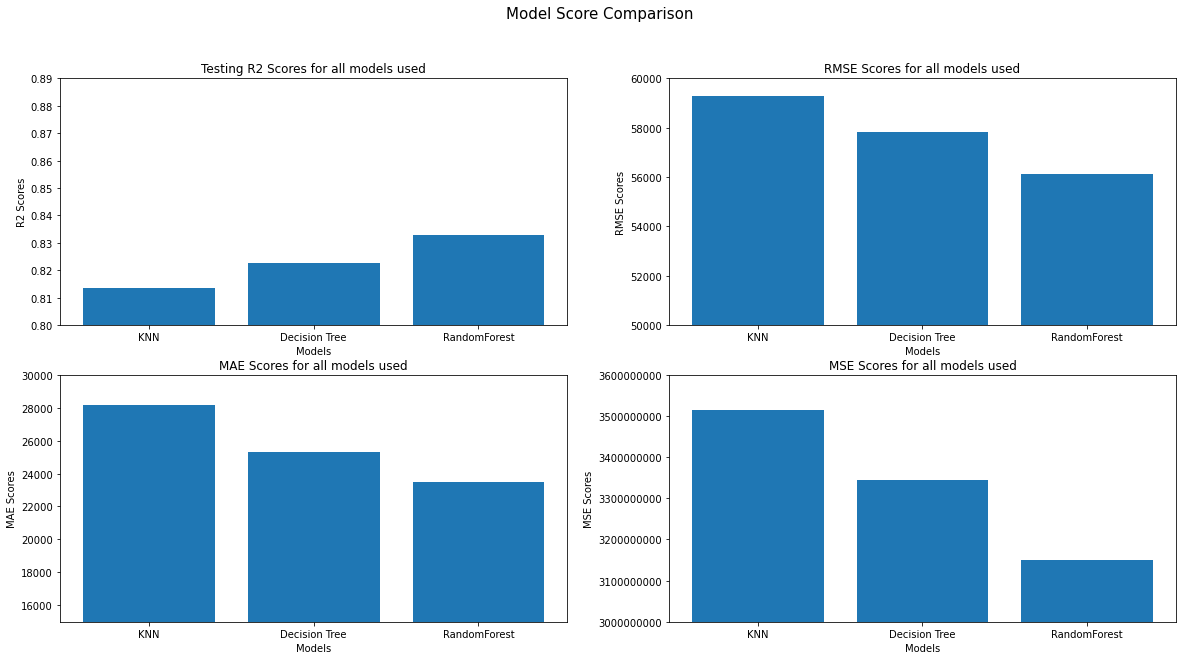


Graph 1: For this graph the highest score is the best so in this case the random forest model had the highest testing r2 score.

For the next 3 graphs the lowest score is the best since you are looking for the least amount of error. There is a consistant trend
with in all three graphs that KNN is the highest and Random Forest is the lowest. With this being said its clear that the best model 
of the three is the Random Forest model based on all these scores


In [232]:
r2scores = [knn_r2_test, dt_r2_test, rf_r2_test]
rmsescores = [knn_rmse_test, dt_rmse_test, rf_rmse_test]
maescores = [knn_mae_test, dt_mae_test, rf_mae_test]
msescores= [knn_mse_test, dt_mse_test, rf_mse_test]
names = ['KNN', 'Decision Tree', 'RandomForest']

fig = plt.figure(figsize=(20,10))
fig.suptitle('Model Score Comparison', fontsize=15)

ax1= plt.subplot(221)
ax2= plt.subplot(222)
ax3= plt.subplot(223)
ax4= plt.subplot(224)


ax1.bar(names, r2scores)
ax1.set_title('Testing R2 Scores for all models used')
ax1.set_ylabel('R2 Scores')
ax1.set_xlabel('Models')
ax1.set_ylim(.8)
ax1.set_yticks(np.arange(.8,.9,.01))


ax2.bar(names, rmsescores)
ax2.set_title('RMSE Scores for all models used')
ax2.set_ylabel('RMSE Scores')
ax2.set_ylim(50000, 60000)
ax2.set_xlabel('Models')

ax3.bar(names, maescores)
ax3.set_title('MAE Scores for all models used')
ax3.set_ylabel('MAE Scores')
ax3.set_ylim(15000, 30000)
ax3.set_xlabel('Models')



ax4.bar(names, msescores)
ax4.set_title('MSE Scores for all models used')
ax4.set_ylabel('MSE Scores')
ax4.set_ylim(3000000000, 3600000000)
ax4.ticklabel_format(style='plain', axis='y')
ax4.set_xlabel('Models')
plt.show()

print('''
Graph 1: For this graph the highest score is the best so in this case the random forest model had the highest testing r2 score.\n
For the next 3 graphs the lowest score is the best since you are looking for the least amount of error. There is a consistant trend
with in all three graphs that KNN is the highest and Random Forest is the lowest. With this being said its clear that the best model 
of the three is the Random Forest model based on all these scores''')
